In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
def vis_cliff_walking(qtable, ax):
    q3d = qtable.reshape(4, 12, ag.act_dim)

    maxq2d = np.max(q3d, axis=2)
    ax.imshow(maxq2d)

    for r in range(4):
        for c in range(12):

            q4 = q3d[r, c, :]
            besta = np.argmax(q4)

            if besta == 0: # 0: Move up
                vec = np.array([0, -1])
            elif besta == 1:
                vec = np.array([1, 0])            
            elif besta == 2:
                vec = np.array([0, 1])
            elif besta == 3:
                vec = np.array([-1, 0])
            else:
                raise
            vec = vec * 0.25
            ax.arrow(c, r, vec[0], vec[1], head_width=0.2)

In [ ]:
class Agent():
    def __init__(self, obs_dim, act_dim, c=2.0, epsilon=0.2) -> object:
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.max_dim = obs_dim * act_dim
        self.epsilon = epsilon

        self.qtable = np.random.normal(0, 0.0001, size=(self.obs_dim, self.act_dim))

    

    def a_epsilon_greedy(self, s):
        q_alla = self.qtable[s, :]
        
    
        if np.random.rand() < self.epsilon:
            out_a = np.random.choice(self.act_dim)

        else:
            out_a = np.argmax(q_alla)
        return out_a, q_alla
    




# SARSA(1)

episode 0, t=0
episode 1000, t=80
episode 2000, t=18
episode 3000, t=27
episode 4000, t=16


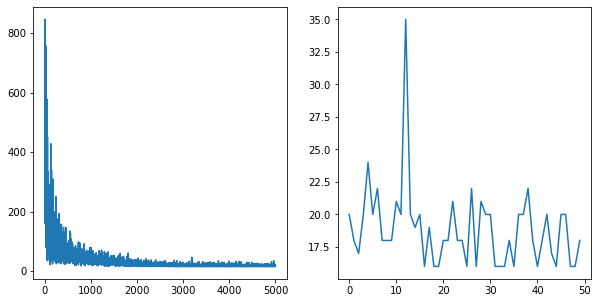

In [ ]:
env = gym.make('CliffWalking-v0')
obs_dim = 48
act_dim = 4
ag = Agent(obs_dim, act_dim, epsilon=0.1)
gamma = 0.98
alpha = 0.01

Niters = 5000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ni % 1000 == 0:
        print('episode %d, t=%d'% (ni, all_ts[ni-1]))
    t = 1
    terminated, truncated = False, False
    s, _ = env.reset()
    
    
    while (terminated is False) :
        
        
        a, q_alla_now = ag.a_epsilon_greedy(s)
        q_now = q_alla_now[a]
        s_next, r_next, terminated, truncated, _ = env.step(a)
        a_next, all_q_next = ag.a_epsilon_greedy(s_next)
        q_next = all_q_next[a_next]


        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        ag.qtable[s, a] += alpha * td_err
        s = s_next

        t += 1

    all_ts[ni] = t


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[-50:])
fig, ax = plt.subplots()
vis_cliff_walking(ag.qtable, ax)
